In [ ]:
import numpy as np
import keras
from keras import layers
import cv2 as cv
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
import keras.utils as image

In [ ]:
#! unzip /content/data.zip

In [ ]:
train_images = sorted(os.listdir('/content/data'))

In [ ]:
train_image = []
for im in train_images:
    img = image.load_img("/content/data/"+ im, target_size=(256,256), color_mode= 'rgb')
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
train_df = np.array(train_image)

In [ ]:
import matplotlib.pyplot as plt

def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(100, 100)
    for i in range(5,10):
        ax[i-5].imshow(dataset[i].reshape(256,256,3), cmap='gray')
    plt.show()

In [ ]:
train_df.shape


(42, 256, 256, 3)

In [ ]:
def add_noice(image):
    row,col,ch= image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss*0.2
    return noisy

In [ ]:
noised_df= []

for img in train_df:
    noisy= add_noice(img)
    noised_df.append(noisy)

In [ ]:
noised_df= np.array(noised_df)


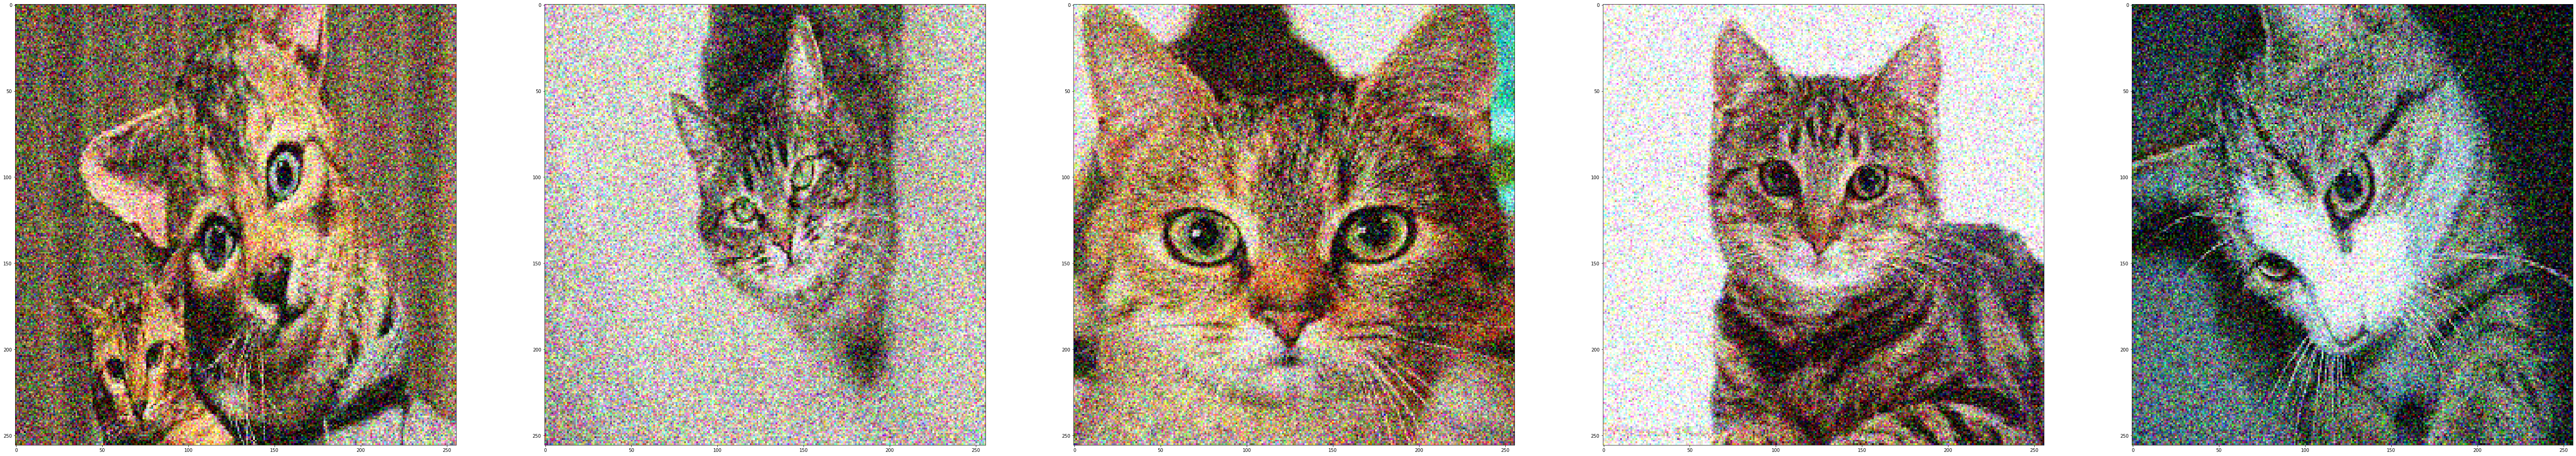

In [ ]:
show_img(noised_df)


In [ ]:
x_trian= train_df[0:35]
y_test= train_df[35:]
noised_trian= noised_df[0:35]
noised_test= noised_df[35:]


In [ ]:
print(x_trian.shape)
print(noised_trian.shape)
print(y_test.shape)
print(noised_test.shape)


(35, 256, 256, 3)
(35, 256, 256, 3)
(7, 256, 256, 3)
(7, 256, 256, 3)


In [ ]:
input_img = keras.Input(shape=(256, 256, 3))

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same',name="encoded")(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
autoencoder.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_30 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_31 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_32 (Conv2D)          (None, 64, 64, 64)        369

In [ ]:
autoencoder.fit(noised_trian, x_trian,
                epochs=4,
                batch_size=128,
                shuffle=True,
                validation_data=(noised_test, y_test))


Epoch 1/4
1/1 [==============================] - 20s 20s/step - loss: 0.6936 - accuracy: 0.1533 - val_loss: 0.6876 - val_accuracy: 0.8625
Epoch 2/4
1/1 [==============================] - 19s 19s/step - loss: 0.6892 - accuracy: 0.7871 - val_loss: 0.6797 - val_accuracy: 0.8625
Epoch 3/4
1/1 [==============================] - 19s 19s/step - loss: 0.6842 - accuracy: 0.7871 - val_loss: 0.6709 - val_accuracy: 0.8625
Epoch 4/4
1/1 [==============================] - 20s 20s/step - loss: 0.6746 - accuracy: 0.7871 - val_loss: 0.6558 - val_accuracy: 0.8625


In [ ]:
"""autoencoder.fit(x_trian, x_trian,
                epochs=4,
                batch_size=128,
                shuffle=True,
                validation_data=(y_test, y_test))
"""

'autoencoder.fit(x_trian, x_trian,\n                epochs=4,\n                batch_size=128,\n                shuffle=True,\n                validation_data=(y_test, y_test))\n'

In [ ]:
#decoded_imgs = autoencoder.predict(noised_test)
decoded_noise_imgs = autoencoder.predict(noised_test)


1/1 [==============================] - 1s 810ms/step


1/1 [==============================] - 1s 597ms/step


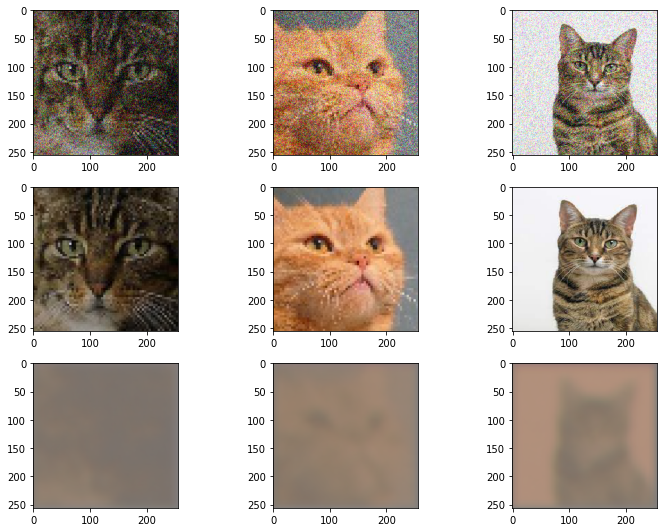

In [ ]:
import cv2

pred= autoencoder.predict(noised_test[:5])
def plot_predictions(y_true, y_pred):
    f, ax = plt.subplots(3, 3)
    f.set_size_inches(10.5,7.5)
    for i in range(3):
        ax[0][i].imshow(np.reshape(noised_test[i], (256,256,3)))
        ax[1][i].imshow(np.reshape(y_true[i], (256,256,3)))
        ax[2][i].imshow(np.reshape(y_pred[i], (256,256,3)))

    plt.tight_layout()
plot_predictions(y_test[:5], pred[:5])

In [ ]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(y_test)

1/1 [==============================] - 0s 433ms/step


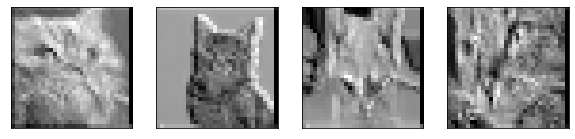

In [ ]:
n = 4
plt.figure(figsize=(10, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i,:,:,0].reshape((32, 32)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
encoded_imgs.shape

(7, 32, 32, 64)

In [ ]:
encoded_imgs[0]

In [ ]:
encoded_noised_V= []

for img in encoded_imgs:
    noisy= add_noice(img)
    encoded_noised_V.append(noisy)


In [ ]:
encoded_noised_V = np.array(encoded_noised_V)


In [ ]:
encoded_noised_V.shape

(7, 32, 32, 64)

In [ ]:
encoded_input = keras.Input(shape=(32, 32, 64))

x = layers.Conv2DTranspose(64, (3, 3), strides=(2,2), activation='relu', padding='same')(encoded_input)
x = layers.Conv2DTranspose(64, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
last = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

decoder = keras.Model(encoded_input, last)
decoder.compile(optimizer='adam', loss='binary_crossentropy')
decoder.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 32, 64)]      0         
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 64, 64, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 128, 128, 64)     36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_26 (Conv2D  (None, 256, 256, 64)     36928     
 Transpose)                                                      
                                                                 
 conv2d_41 (Conv2D)          (None, 256, 256, 3)       1731      
                                                          

In [ ]:
autoencoder.weights[i]
decoder.weights[i].shape


TensorShape([64])

In [ ]:
k = 0
for i in range (8,8):
    decoder.weights[k].assign(autoencoder.weights[i])
    k = k+1

In [ ]:
decoded_imgs2 = decoder.predict(encoded_noised_V)

1/1 [==============================] - 1s 656ms/step


In [ ]:
decoded_imgs2.shape
decoded_imgs2[0].shape

(256, 256, 3)

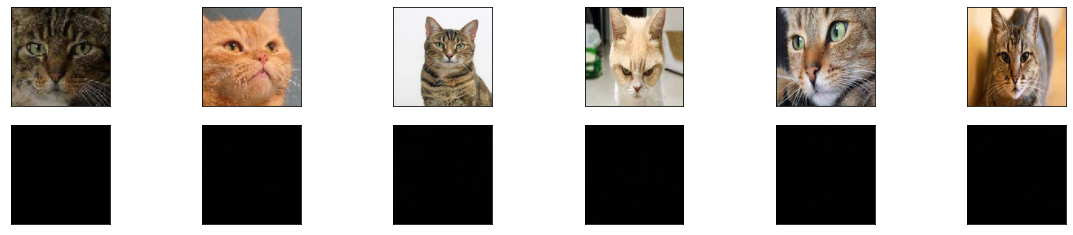

In [ ]:
n = 6  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(y_test[i].reshape(256, 256,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs2[i].reshape(256, 256,3))

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
'''import matplotlib.pyplot as plt

n = 11
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(y_test[i].reshape(256, 256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(256, 256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()'''

'import matplotlib.pyplot as plt\n\nn = 11\nplt.figure(figsize=(20, 4))\nfor i in range(1, n + 1):\n    # Display original\n    ax = plt.subplot(2, n, i)\n    plt.imshow(y_test[i].reshape(256, 256,3))\n    plt.gray()\n    ax.get_xaxis().set_visible(False)\n    ax.get_yaxis().set_visible(False)\n\n    # Display reconstruction\n    ax = plt.subplot(2, n, i + n)\n    plt.imshow(decoded_imgs[i].reshape(256, 256,3))\n    plt.gray()\n    ax.get_xaxis().set_visible(False)\n    ax.get_yaxis().set_visible(False)\nplt.show()'